# Data Wrangling


In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, PrecisionRecallDisplay, f1_score, plot_confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import warnings
from scipy.misc import derivative
warnings.filterwarnings('ignore')

# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.options.mode.chained_assignment = None

#Load in the csv-file
telco_raw = pd.read_csv(r"C:\Users\motox\OneDrive\Data Science Coding\Telco Churn Prediction\WA_Fn-UseC_-Telco-Customer-Churn.csv")

#See what kind of f´data is in the columns
print(telco_raw.columns)

#Identify colulmns of numerical data
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

#Identify colulmns of categorical data
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',\
                           'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',\
                          'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

#Filter out the relevant columns
telco_filtered = telco_raw[num_cols + cat_cols]

#Check if all columns of numerical data have the right data type
print(telco_filtered[num_cols].info())

#The column 'TotalCharges' is not in the right format, so let's transform it!
telco_filtered['TotalCharges'] = pd.to_numeric(telco_raw['TotalCharges'], errors='coerce')
telco_raw['TotalCharges'] = pd.to_numeric(telco_raw['TotalCharges'], errors='coerce')

#Check if any NaNs appeared
print(telco_filtered.isna().sum())

#It seems like that there are 11 rows in the 'TotalCharges'-columns that are unaccounted for.
#Considering the total number of rows in the DataFrame we can just drop those rows without losing vital information
telco_filtered = telco_filtered.dropna()

#Check if it really worked
print(telco_filtered.isna().sum())
#(It did)

#Check if all columns of numerical data have the right data type
print(telco_filtered[cat_cols].info())
#(They are)

#Now we have to bring the column we want to predict, 'Churn' in the right format by turning 'Yes' and 'No' to 1 and 0
telco_filtered['Churn'] = telco_raw['Churn'].replace(['Yes', 'No'], [1, 0])
print(telco_filtered.info())

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   MonthlyCharges  7043 non-null   float64
 2   TotalCharges    7043 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 165.2+ KB
None
tenure               0
MonthlyCharges       0
TotalCharges        11
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
PhoneService         0
MultipleLines        0
InternetServ

# Plotting of numerical data before preprocessing
Plot the numerical data to see if there are any patterns emerging between customers that churned and those that didn't.

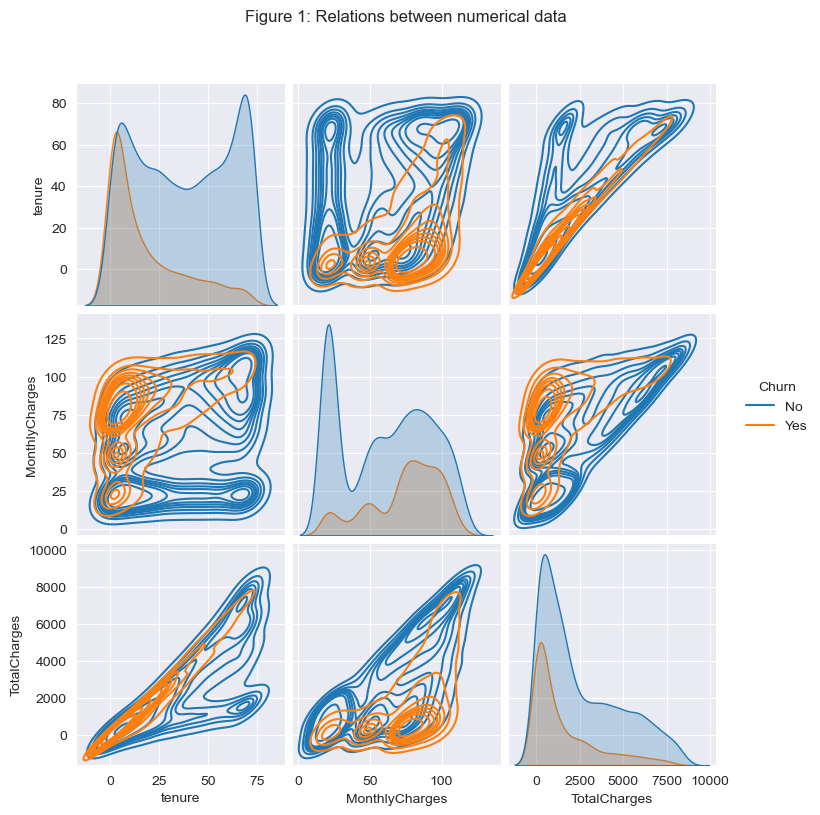

In [2]:
#Plot a Pirplot
sns.set_style('darkgrid')
g = sns.pairplot(data=telco_raw[num_cols+['Churn']], hue='Churn', kind="kde")
g.fig.suptitle('Figure 1: Relations between numerical data', y=1.08)
plt.show()

As you can see in the Pairplot there seems to be a maximum and minimum amount of possible monthly and therefore total charges. All possible combinations of payments in the plots in position (0, 2), (2, 0) are limited by an up- and downwards bound. In the plots (1, 0) and (0, 1) it is apparent that minimum mothly charge is around 20 Dollars and the maximum around 120 Dollars.

The next plot will visualize the relationship between the 'Churn'-Outcomes we want to predict.

0    5163
1    1869
Name: Churn, dtype: int64


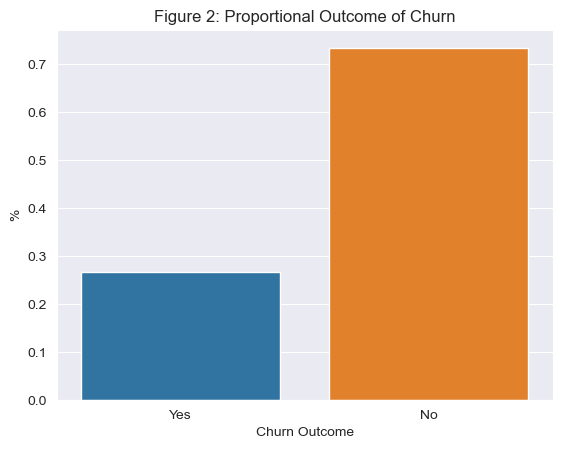

In [3]:
print(telco_filtered['Churn'].value_counts())
churn_percentile = telco_filtered['Churn'].value_counts(normalize=True)
churn_plot = sns.barplot(x=['Yes', 'No'], y=[churn_percentile[1], churn_percentile[0]])
churn_plot.set(xlabel ="Churn Outcome", ylabel='%', title ='Figure 2: Proportional Outcome of Churn')
plt.show()

As we can see in the Barplot the target variable, 'Churn', is rather inbalanced so the metric 'Accuracy' represents an insufficient way of deciding which model performs the best. In the following part we will upsample the minority class, which is represented by 'Yes'(1), to achieve a balanced data set. The reason for doing that is that metrics like 'Accuracy' have more significance and finding a good model is therefore easier.

# Upsampling of minority class data

In [4]:
#First we separate the data into minority and majority classes. The target variable 
telco_minority = telco_filtered[telco_filtered['Churn']==1]
telco_majority = telco_filtered[telco_filtered['Churn']==0]

#Now we upsample the minority class to the size of the majority class with the sklearn resample package
telco_minority_upsample = resample(telco_minority, replace=True, n_samples=len(telco_majority))

#The last step consists of combining the two DataFrames
telco_data = pd.concat([telco_minority_upsample, telco_majority])

Now we plot churn outcome of the sampled data again

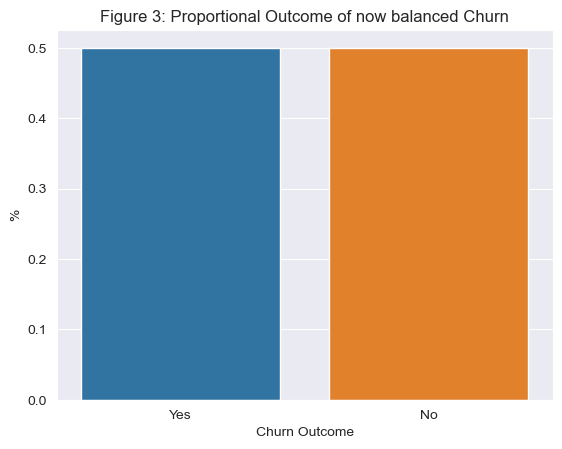

In [5]:
churn_percentile_sampled = telco_data['Churn'].value_counts(normalize=True)
churn_sampled_plot = sns.barplot(x=['Yes', 'No'], y=[churn_percentile_sampled[1], churn_percentile_sampled[0]])
churn_sampled_plot.set(xlabel ="Churn Outcome", ylabel='%', title ='Figure 3: Proportional Outcome of now balanced Churn')
plt.show()

As we can see now the data is perfectly balanced and 'Accuracy' is now a viable metric.

# Preprocessing of numerical and categorical data

In [6]:
#Now separate target data 'y',which we want to predict, and feature data X into separate DataFrames 
y = telco_data['Churn']

X = telco_data[cat_cols + num_cols]

#We are going to use the sklearn 'make_column_selector' to split the data into categorical and numerical data
#Initiate the selector
num_cols_selector = selector(dtype_exclude=object)
cat_cols_selector = selector(dtype_include=object)

#Split the data
num_col = num_cols_selector(X)
cat_col = cat_cols_selector(X)

#Assign columns to a specific processor. 'One-Hot-Encoding' will be used on categorical data and scaling on numerical data
cat_preprocessor = OneHotEncoder(handle_unknown="ignore")
num_preprocessor = StandardScaler()

#Now associate each of these preprocessors with their respective columns using the 'ColumnTransformer' package
preprocessor = ColumnTransformer([('one-hot-encoder', cat_preprocessor, cat_col),
                                  ('standard_scaler', num_preprocessor, num_col)])

# Split the data into train and test data

In [7]:
#Initiate the 'train_test_split'-package
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42069, stratify=y)

#Ininitialize KFold for cross validation of the model to prevent overfitting
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Initiating several binary classifier models
To make sure that the model's best version is used, we will optimize the hyperparameters by using the package GridSearchCV.

First we are going to define an empty dictionary which will be filled with the selected models and a dummy model to put it into comparison.

In [8]:
#Initiate an empty dictionary later containing the models
models = {}

#To evaluate a models performance, other than looking at simple numerical metrics, comparison with a dummy model can be of interest 
models['Dummy Model'] = make_pipeline(preprocessor, DummyClassifier(strategy='prior'))

In [9]:
#Logistic Regression
#Define the steps of the pipeline
log_steps = [('preprocessor', preprocessor), ('log', LogisticRegression(max_iter=1000))]

#Initialize the pipeline
log_pipeline = Pipeline(log_steps)

#Define dictionary of lists of hyperparameters to test out
log_parameters = {'log__solver':['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
              'log__penalty': ['l1', 'l2', 'elasticnet', 'none']}

#Initialize the model
models['Logistic Regression'] = GridSearchCV(log_pipeline, param_grid=log_parameters, cv=kf, scoring='roc_auc', n_jobs=-1)

Defining a svc model

In [10]:
#Support Vector Machines
#Define the steps of the pipeline
svc_steps = [('preprocessor', preprocessor), ('svc', SVC(gamma='auto'))]

#Initialize the pipeline
svc_pipeline = Pipeline(svc_steps)

#Define dictionary of lists of hyperparameters to test out
svc_parameters = {'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
              'svc__degree': [1, 2, 3, 4]}

#Initialize the model
models['Support Vector Machines'] = GridSearchCV(svc_pipeline, param_grid=svc_parameters, cv=kf, scoring='roc_auc', n_jobs=-1)

Defining a logistic regression model

In [11]:
#Gradient Boosting
#Define the steps of the pipeline
hist_steps = [('preprocessor', preprocessor), ('hist', HistGradientBoostingClassifier(max_iter=1000))]

#Initialize the pipeline
hist_pipeline = Pipeline(hist_steps)

#Define dictionary of lists of hyperparameters to test out
hist_parameters = {'hist__loss':['log_loss', 'auto', 'binary_crossentropy', 'categorical_crossentropy', 'newton-cg'],
              'hist__max_depth': list(range(1,100,10))}

#Initialize the model
models['Gradient Boosting'] = GridSearchCV(hist_pipeline, param_grid=hist_parameters, cv=kf, scoring='roc_auc', n_jobs=-1)

Defining a naive bayes model

In [12]:
#Naive Bayes
#Define the steps of the pipeline
bayes_steps = [('preprocessor', preprocessor), ('bayes', GaussianNB())]

#Initialize the pipeline
bayes_pipeline = Pipeline(bayes_steps)

#Define dictionary of lists of hyperparameters to test out
bayes_parameters = {'bayes__var_smoothing':[1e-5, 1e-6, 1e-7, 1e-8, 1e-9]}

#Initialize the model
models['Naive Bayes'] = GridSearchCV(bayes_pipeline, param_grid=bayes_parameters, cv=kf, scoring='roc_auc', n_jobs=-1)

Defining a KNN model

In [13]:
#K-Nearest Neighbors
#Define the steps of the pipeline
knn_steps = [('preprocessor', preprocessor), ('knn', KNeighborsClassifier(n_jobs=-1))]

#Initialize the pipeline
knn_pipeline = Pipeline(knn_steps)

#Define dictionary of lists of hyperparameters to test out
knn_parameters = {'knn__weights':['uniform', 'distance'],
              'knn__n_neighbors': list(range(1,20))}

#Initialize the model
models['K-Nearest Neighbors'] = GridSearchCV(knn_pipeline, param_grid=knn_parameters, cv=kf, scoring='roc_auc', n_jobs=-1)

Defining a Multi-Layer-Perceptron-Classifier

In [14]:
#Multi-Layer-Perceptron
#Define the steps of the pipeline
mlp_steps = [('preprocessor', preprocessor), ('mlp', MLPClassifier())]

#Initialize the pipeline
mlp_pipeline = Pipeline(mlp_steps)

#Define dictionary of lists of hyperparameters to test out
mlp_parameters = {'mlp__alpha':list(10.0 ** -np.arange(1, 7))}

#Initialize the model
models['Multi-Layer-Perceptron'] = GridSearchCV(mlp_pipeline, param_grid=mlp_parameters, cv=kf, scoring='roc_auc', n_jobs=-1)

# Fitting the models to the train data and calculating their respective scoring metrics

In [15]:
#Initiating the scoring dictionaries
cv, accuracy, precision, recall, roc = {}, {}, {}, {}, {}

#Fit all models separately and populate the scoring metrics
for key in models.keys():
    
    #Fit the classifier model
    models[key].fit(X_train, y_train)
    #Prediction
    if key != 'Dummy Model':
        predictions = models[key].best_estimator_.predict(X_test)
    else:
        predictions = models[key].predict(X_test)
        
    #Calculate CV-Score, Accuracy, Precision, Recall and ROC-AUC-Score metrics
    if key != 'Dummy Model':
        cv[key] = cross_val_score(models[key].best_estimator_, X_train, y_train, cv=kf).mean()
    else:
        cv[key] = cross_val_score(models[key], X_train, y_train, cv=kf).mean()
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    if ((key != 'Support Vector Machines') and (key != 'Dummy Model')):
        roc[key] = roc_auc_score(y_test, models[key].best_estimator_.predict_proba(X_test)[:, 1])
    elif key == 'Dummy Model':
        roc[key] = roc_auc_score(y_test, models[key].predict_proba(X_test)[:, 1])
    else:
        roc[key] = 0

In [16]:
#Putting all scoring metrics into a DataFrame
df_model = pd.DataFrame(index=models.keys(), columns=['CV-Score', 'Accuracy', 'Precision', 'Recall'])
df_model['CV-Score'] = cv.values()
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['ROC-AUC-Score'] = roc.values()
df_model

,CV-Score,Accuracy,Precision,Recall,ROC-AUC-Score
Dummy Model,0.487216,0.500000,0.000000,0.000000,0.500000
Logistic Regression,0.762396,0.766847,0.798606,0.750910,0.840395
Support Vector Machines,0.740183,0.733153,0.821069,0.698287,0.000000
Gradient Boosting,0.878490,0.886135,0.943455,0.846421,0.950709
Naive Bayes,0.735148,0.734314,0.852827,0.689418,0.805776
K-Nearest Neighbors,0.820508,0.818358,0.962820,0.746995,0.968791
Multi-Layer-Perceptron,0.793649,0.808288,0.848954,0.785100,0.875754


# Plotting the scoring metrics

<Figure size 3600x2400 with 0 Axes>

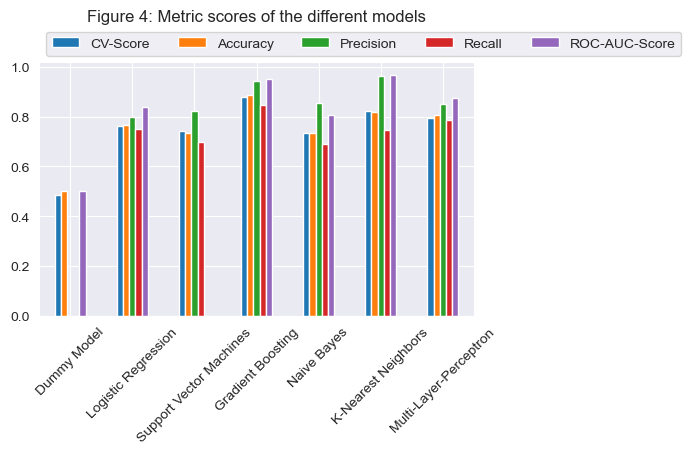

In [17]:
ax=plt.figure(figsize=(36,24))
ax = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
plt.title('Figure 4: Metric scores of the different models', y=1.13)
plt.tight_layout()
plt.show()

As we can see now all models outperform our dummy baseline model.

# Plotting the feature importance
To have a first look which features have the most effect on churn we can directly plot the coefficients of the logistic regression model and sort them by size

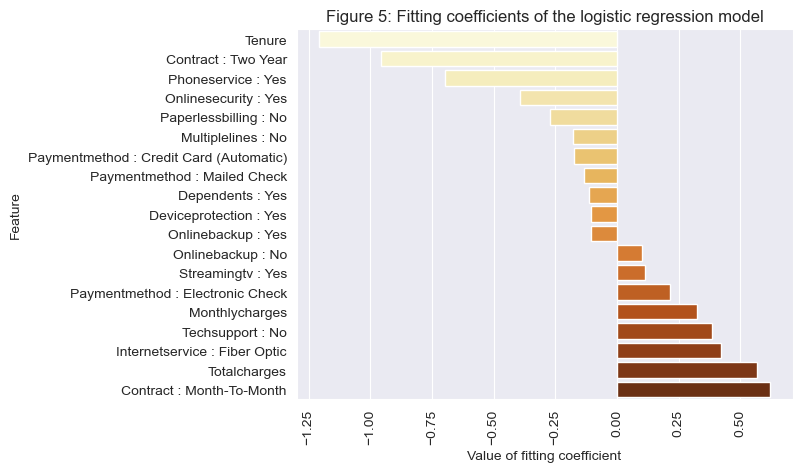

In [18]:
#Get feature importance
log_importance = pd.DataFrame({'Value of fitting coefficient' : models['Logistic Regression'].best_estimator_.named_steps['log'].coef_ [0].flatten()})

#Filter out only the significant feature importances above
threshold = 0.1
log_importance_filter = abs(log_importance['Value of fitting coefficient']) > threshold
log_importance_filtered = log_importance[log_importance_filter]

#Get the filtered feature names
log_feature_names_raw = pd.DataFrame({'Feature' : log_pipeline[:-1].get_feature_names_out()})[log_importance_filter]

#Clean up the feature names
log_feature_names = log_feature_names_raw['Feature']\
                    .str.removeprefix('standard_scaler__')\
                    .str.removeprefix('one-hot-encoder__')\
                    .str.replace('_',' : ')\
                    .str.title().str.replace('Dsl', 'DSL')

#Create the DataFrame consisting of feature names and feature importances
log_features = pd.concat([log_feature_names, log_importance_filtered], axis=1).sort_values('Value of fitting coefficient')


#Plot the relevant feature importances
sns.color_palette("rocket")
sns.barplot(data=log_features, y=log_features['Feature'], x=log_features['Value of fitting coefficient'], palette='YlOrBr')
plt.xticks(rotation=90)
plt.title('Figure 5: Fitting coefficients of the logistic regression model', y=1.0)
plt.yticks(fontsize=10)
plt.show()

We can now see the values of the fitting coefficients of the logistic regression model according to each feature. The size of those coeficients can be interpreted as the ability of that feature to predict the outcome of churn. Having that in mund we can see that for example 'Tenure' has a high negative impact on churn outcome, meaning that the higher the 'Tenure' the less likely a churn outcome of 1('Yes') is. On the other hand are high 'Totalcharges' or a customer having a month-to-month contract a good indicator that customers might churn.

Another way of calculating the feature importance is via permutation importance. Here each feature is permutated or resampled while the remaining features stay as they are. This obscures the predictive value of that feature and the loss of accuracy of target prediction is plotted. In this example we will use the Gradient Boosting Model, as that seems to have the most consistent scores across all scoring metrics.

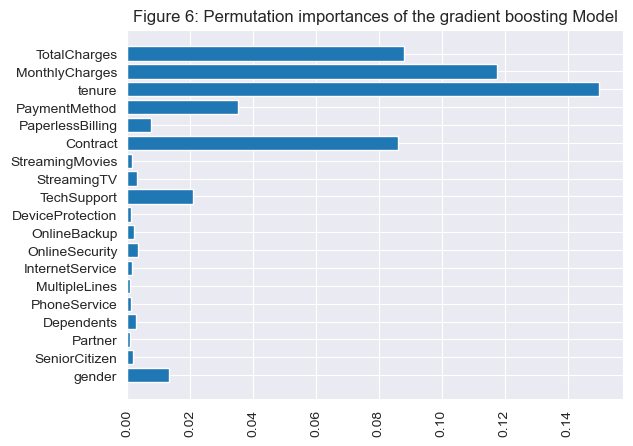

In [19]:
#Now the permutation importances will be calculated
results = permutation_importance(models['Gradient Boosting'].best_estimator_, X_test, y_test, scoring='accuracy')
importance = abs(results.importances_mean)

#Bar plot of the feature importances
plt.barh(X.columns, importance)
plt.title('Figure 6: Permutation importances of the gradient boosting Model', y=1.0)
plt.xticks(rotation=90)
plt.yticks(fontsize=10)
plt.show()

As we can see now the most important features seem to be 'TotalCharges', 'MonthlyCharges', 'Contract' and 'Tenure'. In order to postively effect churn outcome, meaning less customers canceling their contract, those are the features that would have to be altered. 

# Creating a business plan to decrease churn

Now we will try to decrease churn by lowering the highest monthly charges, as it is the easiest feature to alter out of the most important ones. To see the effects we will be fitting our model to the altered data and check if it has significant impact on churn rate. First we will change the original data by lowering all rows in the 'MonthlyCharge'-column by a certain factor. Our goal is to achieve a larger decrease in churn than a decrease in monthly charges as that will secure a higher profit.

In [20]:
#Create the factors with which the 'MonthlyCharges'-column will be multiplied with
factor = [x / 1000 for x in list(range(750,1000, 1))]

#Create a copy of the original data
X_changed = X.copy()

In [21]:
#Create list of calculated churn rates with the new churn rates
churn_rate = []
for i in factor:
    X_changed['MonthlyCharges'] = X['MonthlyCharges']*i
    y_prediction = models['Gradient Boosting'].best_estimator_.predict(X_changed)
    churn_rate.append(y_prediction.mean())

In [22]:
#Create new DataFrame containing the data
churn_dict = {'Churn Rate' : churn_rate, 'Proportion of Mean Monthly Charge' : factor}
churn_df = pd.DataFrame(churn_dict)

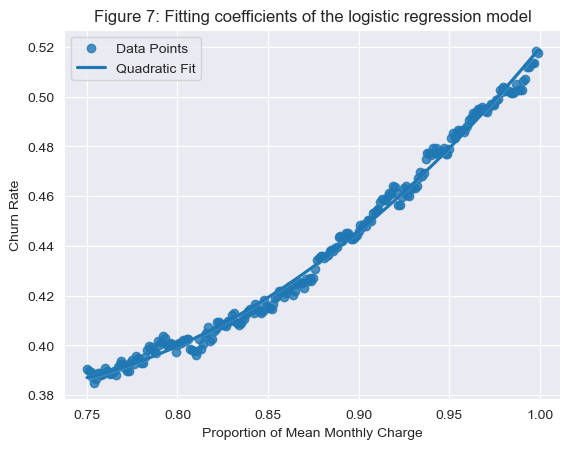

In [23]:
#Plot a Data with a quadratic fit
churn_rate_plot = sns.regplot(data=churn_df, x='Proportion of Mean Monthly Charge', y='Churn Rate', order=2)
plt.legend(labels=['Data Points', 'Quadratic Fit'])
plt.title('Figure 7: Fitting coefficients of the logistic regression model', y=1.0)
plt.show()

As we can see in figure 7 the churn rate decreses as we decrease the monthly charge. Our goal is to achieve a change in churn rate that is higher than a change in mean monthly charge as that would mean that total revenue is still increasing. So now we have to calculate the derivative of the fitted quadratic function and see if there is any point where the slope is higher than 1.

In [24]:
#Generation of the fitting parameters
fit_params = np.polyfit(churn_df['Proportion of Mean Monthly Charge'], churn_df['Churn Rate'], 2)
print(fit_params)

[ 1.38257876 -1.88929811  1.02625871]


In [25]:
#Define the fitting function
def f(x): return fit_params[0]*x**2 + fit_params[1]*x + fit_params[2]

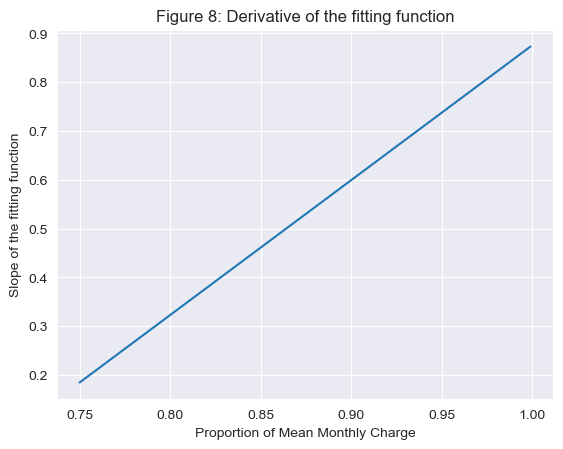

In [26]:
#Plot the derivative
plt.plot(churn_df['Proportion of Mean Monthly Charge'],derivative(f,churn_df['Proportion of Mean Monthly Charge'], dx=0.001))
plt.title('Figure 8: Derivative of the fitting function', y=1.0)
plt.ylabel('Slope of the fitting function')
plt.xlabel('Proportion of Mean Monthly Charge')
plt.show()

# Summary
As we can observe in the figure 8 there is no point where the derivative function exceeds the value of 1, meaning that this business plan would not be successful. Looking back at figure 1 we can see that most people that churn a located in the upper bounds of monthly charges, so in an alternative plan it would be sensible to concentrate lowering the monthly charge only to the most expensive contract or customers who pay the most monthly. 